In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
from PIL import ImageDraw
import math
plt.style.use({'figure.figsize':(10, 10)})

In [2]:
Epsilon_start=1
Epsilon_final=0.01
Robot_radium=40
Decay_rate=0.000001#he dacaying rate of the Epsilon, the range of the epsilon is 0.01-1, initially it is 1.
Action_times=0 #Rigister the totality of the times of selecting actions, including the random selections and selection based on Q_Table
Velocity_tripod=0.289*Robot_radium
Beta=0.9
Alpha=0.2

In [3]:
Q_table2_states=np.array(['L60D0/30','L180D0/30','L250D0/30','L300D0/30',
                'L60D30/60','L180D30/60','L250D30/60','L300D30/60',
                 'L60D60/90','L180D60/90','L250D60/90','L300D60/90',
                'L60D90/120','L180D90/120','L250D90/120','L300D90/120',
                'L60D120/150','L180D120/150','L250D120/150','L300D120/150',
                'L60D150/180','L180D150/180','L250D150/180','L300D150/180',
                'L60D180/210','L180D180/210','L250D180/210','L300D180/210',
                'L60D210/240','L180D210/240','L250D210/240','L300D210/240',
                'L60D240/270','L180D240/270','L250D240/270','L300D240/270',
                'L60D270/300','L180D270/300','L250D270/300','L300D270/300',
                'L60D300/330','L180D300/330','L250D300/330','L300D300/330',
                 'L60D330/360','L180D330/360','L250D330/360','L300D330/360'])
Q_table2_action=np.array(['Up','Left_45D','Right_45D'])
Q_table2_actions_length=len(Q_table2_action)
Q_table2_states_length=len(Q_table2_states)
Q_table2_real=np.zeros((Q_table2_states_length,Q_table2_actions_length))
Q_table2_real=pd.DataFrame(Q_table2_real,columns=Q_table2_action,index=Q_table2_states)
Q_table2_real.head()

,Up,Left_45D,Right_45D
L60D0/30,0.0,0.0,0.0
L180D0/30,0.0,0.0,0.0
L250D0/30,0.0,0.0,0.0
L300D0/30,0.0,0.0,0.0
L60D30/60,0.0,0.0,0.0


In [4]:
def Set_destination(x,y):
    return x,y
# Destination_x,Destination_y=Set_destination(900,900)

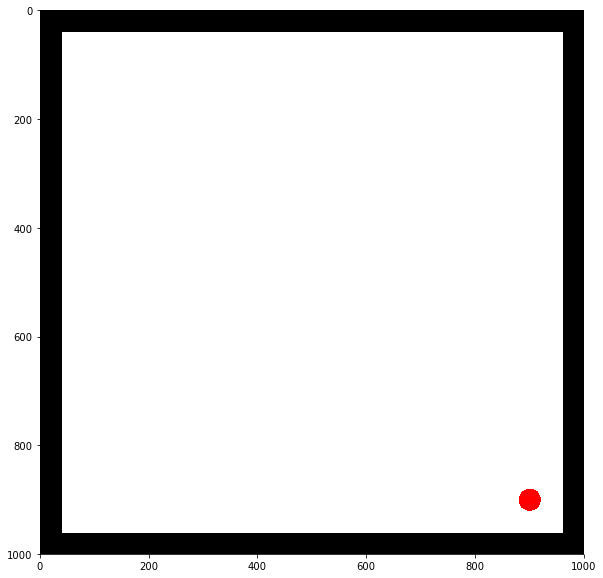

In [5]:
#Draw_map2 funcion is used to train the first Q-Table2, which allows it to arrive to the destination
def Draw_map(Destination_x,Destination_y):
    im = Image.new("RGB", size=(1000,1000),color=(0,0,0)) 
    draw = ImageDraw.Draw(im,mode='RGB')
    draw.rectangle((40,40,960,960),(255,255,255),(255,255,255))
    draw.ellipse((Destination_x-20,Destination_y-20,Destination_x+20,Destination_y+20), (255,0,0), (255,0,0)) 
    return im
im=Draw_map(900,900)
plt.imshow(im)
plt.show()

In [6]:
def Initial_Q_Table2(LengthOfActions,LengthOfStates):
    Q_table2=np.zeros((LengthOfStates,LengthOfActions))
    print('***********************************************************')
    print("Succeed to initialize Q-table2!")
    print('***********************************************************')
    return Q_table2

In [7]:
def Robot_destination(Destination_x,Destination_y,Current_x,Current_y,Current_angle):
    #Left-negative,180-360 |||| Right-positive,0-180
    Delta_x=Destination_x-Current_x
    Delta_y=Destination_y-Current_y
    Distance=np.sqrt(Delta_x*Delta_x+Delta_y*Delta_y)
    Direct_angle=(np.arctan(Delta_y/Delta_x))*180/np.pi
    if Delta_x<0:
        Direct_angle=Direct_angle+180
    True_angle=(Current_angle-Direct_angle)%360
#     print(true_angle)
    if True_angle>180:
        return 360-True_angle,'right',Distance
    else:
        return True_angle,'left',Distance

In [8]:
#Is_Crash function, in the second map, is used to judge if the robot collides with the black frame
def Is_Crash(Current_x,Current_y,im):
    Crash=False
    Degree=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
    Dis=np.arange(0,50,5)
    for i in Dis:
        for j in Degree:
            x=Current_x+i*np.cos(j/180*np.pi)
            y=Current_y+i*np.sin(j/180*np.pi)
            if (im.getpixel((x,y)))==(0,0,0):
                Crash=True
                break
        if Crash==True:
                break
    return Crash

In [9]:
def Is_arrive(Current_x,Current_y,im):
    Arrive=False
    Crash=False
    Degree=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
    Distance=np.arange(0,40,5)
    for i in Distance:
        for j in Degree:
            x=Current_x+i*np.cos(j/180*np.pi)
            y=Current_y+i*np.sin(j/180*np.pi)
            if (im.getpixel((x,y)))==(0,0,0):
                Crash=True
                break
            if (im.getpixel((x,y)))==(255,0,0):
                Arrive=True
                break
        if Arrive==True or Crash==True:
                break
    return Arrive
# print(Is_arrive(500,500))

In [10]:
#Random_start function, in the second map, is used to set the beginning point in the white map.
def Random_start(im):
    Angle=0
    x,y=np.random.random(2)*1000
    while(Is_Crash(x,y,im)==True or Is_arrive(x,y,im)==True):
#         print('Boom')
        x,y=np.random.random(2)*1000
    return x,y,Angle

In [11]:
def Output_state_index(True_angle,Left_right,Distance):
    if 0<=Distance<60:
        Distance_level=0
    elif 60<=Distance<180:
        Distance_level=1
    elif 180<=Distance<250:
        Distance_level=2
    else:
        Distance_level=3
    Angle_level=True_angle//30
    
    if Left_right=='right':
        Left_right_level=1
        State_number=int(Distance_level+24*Left_right_level+(5-Angle_level)*4)
    elif Left_right=='left':
        Left_right_level=0
        Angle_level=True_angle//30
        State_number=int(Distance_level+24*Left_right_level+Angle_level*4)
    return State_number,Distance_level,Angle_level
# State_Number,_,_=Output_state_index(20,'right',299) #180 belongs to 180-210,''right' does not have 180
# Q_table2_states[State_Number]
    
    
    

In [12]:
def Choose_action2(Q_Table,Current_state,Action_times):
    Epsilon=Epsilon_final+(Epsilon_start-Epsilon_final)*np.exp(-1*Decay_rate*Action_times)
    State_action=Q_Table[Current_state,:]
    if(np.random.random()<Epsilon or np.all(State_action==[0])):
        Next_action=np.random.randint(Q_table2_actions_length)
    else:
        Next_action=np.argmax(State_action)
    return Next_action
# print(Choose_action2(Q_Table2,20,0))

In [13]:
def Output_next_state(Current_x,Current_y,Current_angle,Destination_x,Destination_y,Action,im):
    Arrive=False
    Crash=False
    if Action==0:
        Next_x=Current_x+Velocity_tripod*np.cos(Current_angle/180*np.pi)
        Next_y=Current_y+Velocity_tripod*np.sin(Current_angle/180*np.pi)
        Next_angle=Current_angle
        if Is_Crash(Next_x,Next_y,im)==True:
            Crash=True
        if Is_arrive(Next_x,Next_y,im)==True:
            Arrive=True
    elif Action==1:
        Next_x=Current_x
        Next_y=Current_y
        Next_angle=Current_angle-45
    elif Action==2:
        Next_x=Current_x
        Next_y=Current_y
        Next_angle=Current_angle+45        
    True_angle,Left_right,Distance=Robot_destination(Destination_x,Destination_y,Next_x,Next_y,Next_angle)
    State_number,Distance_level,Angle_level=Output_state_index(True_angle,Left_right,Distance)
    if Arrive==False:
        Reward=Distance_level*-0.5-Angle_level
    elif Arrive==True:
        Reward=50
    return Next_x,Next_y,Next_angle,Reward,State_number,Arrive,Crash
#Next_state_F2(600,600,50,1800,1800,1)

In [14]:
def Movement_plot(Vec_x,Vec_y,Destination_x,Destination_y):
    im=Image.new("RGB", size=(1000,1000),color=(0,0,0))
    draw=ImageDraw.Draw(im,mode='RGB')
    draw.rectangle((40,40,960,960),255,255)
    draw.ellipse((Destination_x-20,Destination_y-20,Destination_x+20,Destination_y+20),(255,0,0),(255,0,0))
    for i,j in zip(Vec_x,Vec_y):
        draw.ellipse((i-40,j-40, i+40,j+40),150,150) 
    return im

# plt.imshow(im)
# plt.show()


In [15]:
Q_Table2=Initial_Q_Table2(Q_table2_actions_length,Q_table2_states_length)
global Epoche
Epoche=0
global Action_times #Rigister the totality of the times of selecting actions, including the random selections and selection based on Q_Table
Action_times=0
global Epoche_action_interval

***********************************************************
Succeed to initialize Q-table2!
***********************************************************


In [16]:
def run2():
    global Epoche
    global Action_times
    global Epoche_action_interval
    global Vec_x
    global Vec_y
    Crash=False
    Arrive=False
    False_epoche=0
    
    Destination_x,Destination_y=Set_destination(900,900)
    im=Draw_map(Destination_x,Destination_y)
    
    Destination_x,Destination_y=Set_destination(900,900)
    Current_x,Current_y,Current_angle=Random_start(im)
    Epoche_false=0
    Vec_x=[]
    Vec_y=[]
    Vec_x.append(Current_x)
    Vec_y.append(Current_y)
    while False_epoche<300:
        True_angle,Left_right,Distance=Robot_destination(Destination_x,Destination_y,
                                                         Current_x,Current_y,Current_angle)
        Current_state_number,Distance_level,Angle_level=Output_state_index(True_angle,
                                                                           Left_right,Distance)
        Next_action=Choose_action2(Q_Table2,Current_state_number,
                                   Action_times)
        Next_x,Next_y,Next_angle,Reward,Next_state_number,Arrive,Crash=Output_next_state(Current_x,Current_y,
                                                                Current_angle,Destination_x,Destination_y,Next_action,im)
        if Crash==True:
            Next_x,Next_y,Next_angle=Random_start(im)
        else:
            if Arrive==True:
                Next_true_angle,Next_left_right,Next_distance=Robot_destination(Destination_x,Destination_y,Next_x,Next_y,Next_angle)
                print('**********************************')
                print('last_x=%f, last_y=%f,last_a=%f'%(Current_x,Current_y,Current_angle%360))
                print('x=%f y=%f True_angle=%f Des_Ro_dis=%f Action=%d S_N=%d'%(Next_x,Next_y,Next_true_angle,
                                                                                Next_distance,Next_action,Next_state_number))
                print(Q_table2_states[Next_state_number])
                print('Des_Robot_a=%f Robot_a=%d'%
                      ((np.arctan((Next_y-Destination_y)/(Next_x-Destination_x)))*180/np.pi,Next_angle%360))
                print(Epsilon_final+(Epsilon_start-Epsilon_final)*np.exp(-1*Decay_rate*Action_times))
                print(Action_times)
                Next_x,Next_y,Next_a=Random_start(im)
                Epoche+=1
                False_epoche+=1
                print('False_epoche=%d'%False_epoche)
            Q_target=Reward+Beta*max(Q_Table2[Next_state_number])
            Q_Table2[Current_state_number][Next_action]+=Alpha*(Q_target-Q_Table2[Current_state_number][Next_action])
            Vec_x.append(Current_x)
            Vec_y.append(Current_y)
        Current_x=Next_x
        Current_y=Next_y
        Current_angle=Next_angle
        Action_times+=1
    return Q_Table2
Q_Table2_final=run2()
        

**********************************
last_x=875.282180, last_y=841.519466,last_a=90.000000
x=875.282180 y=853.079466 True_angle=27.780340 Des_Ro_dis=53.033076 Action=0 S_N=0
L60D0/30
Des_Robot_a=62.219660 Robot_a=90
0.984220771876
16067
False_epoche=1
**********************************
last_x=859.957341, last_y=861.984632,last_a=45.000000
x=868.131496 y=870.158786 True_angle=1.881607 Des_Ro_dis=43.658901 Action=0 S_N=0
L60D0/30
Des_Robot_a=43.118393 Robot_a=45
0.975780848076
24768
False_epoche=2
**********************************
last_x=894.193767, last_y=834.987637,last_a=90.000000
x=894.193767 y=846.547637 True_angle=6.199415 Des_Ro_dis=53.766787 Action=0 S_N=0
L60D0/30
Des_Robot_a=83.800585 Robot_a=90
0.974618747659
25972
False_epoche=3
**********************************
last_x=909.914953, last_y=844.904572,last_a=90.000000
x=909.914953 y=856.464572 True_angle=12.829965 Des_Ro_dis=44.650193 Action=0 S_N=44
L60D330/360
Des_Robot_a=-77.170035 Robot_a=90
0.955780907251
45694
False_epoche

x=857.232921 y=876.690302 True_angle=61.407922 Des_Ro_dis=48.706931 Action=0 S_N=8
L60D60/90
Des_Robot_a=28.592078 Robot_a=90
0.892734912449
114680
False_epoche=36
**********************************
last_x=842.739117, last_y=878.231876,last_a=0.000000
x=854.299117 y=878.231876 True_angle=25.469271 Des_Ro_dis=50.620370 Action=0 S_N=44
L60D330/360
Des_Robot_a=25.469271 Robot_a=0
0.890249986879
117499
False_epoche=37
**********************************
last_x=893.360998, last_y=842.662409,last_a=90.000000
x=893.360998 y=854.222409 True_angle=8.251922 Des_Ro_dis=46.256504 Action=0 S_N=0
L60D0/30
Des_Robot_a=81.748078 Robot_a=90
0.888134651179
119905
False_epoche=38
**********************************
last_x=851.743194, last_y=873.172076,last_a=0.000000
x=863.303194 y=873.172076 True_angle=36.169408 Des_Ro_dis=45.457596 Action=0 S_N=40
L60D300/330
Des_Robot_a=36.169408 Robot_a=0
0.887485071911
120645
False_epoche=39
**********************************
last_x=891.736334, last_y=840.731036,last_

**********************************
last_x=843.177450, last_y=891.618997,last_a=315.000000
x=851.351604 y=883.444843 True_angle=63.793553 Des_Ro_dis=51.388128 Action=0 S_N=36
L60D270/300
Des_Robot_a=18.793553 Robot_a=315
0.842493940483
173279
False_epoche=91
**********************************
last_x=875.277240, last_y=845.624776,last_a=45.000000
x=883.451394 y=853.798931 True_angle=25.293155 Des_Ro_dis=49.075403 Action=0 S_N=44
L60D330/360
Des_Robot_a=70.293155 Robot_a=45
0.840015971294
176260
False_epoche=92
**********************************
last_x=871.204130, last_y=842.241898,last_a=45.000000
x=879.378285 y=850.416053 True_angle=22.417819 Des_Ro_dis=53.701238 Action=0 S_N=44
L60D330/360
Des_Robot_a=67.417819 Robot_a=45
0.839273439333
177155
False_epoche=93
**********************************
last_x=874.604383, last_y=848.917502,last_a=90.000000
x=874.604383 y=860.477502 True_angle=32.723220 Des_Ro_dis=46.978348 Action=0 S_N=4
L60D30/60
Des_Robot_a=57.276780 Robot_a=90
0.8388415004
17

x=856.294577 y=883.329536 True_angle=20.878243 Des_Ro_dis=46.776793 Action=0 S_N=44
L60D330/360
Des_Robot_a=20.878243 Robot_a=0
0.823025068088
196943
False_epoche=124
**********************************
last_x=852.916698, last_y=859.952098,last_a=90.000000
x=852.916698 y=871.512098 True_angle=58.823831 Des_Ro_dis=55.030882 Action=0 S_N=4
L60D30/60
Des_Robot_a=31.176169 Robot_a=90
0.822664165084
197387
False_epoche=125
**********************************
last_x=848.642581, last_y=887.957518,last_a=45.000000
x=856.816735 y=896.131673 True_angle=39.881146 Des_Ro_dis=43.356180 Action=0 S_N=4
L60D30/60
Des_Robot_a=5.118854 Robot_a=45
0.82191604595
198308
False_epoche=126
**********************************
last_x=857.891802, last_y=860.603123,last_a=90.000000
x=857.891802 y=872.163123 True_angle=56.532117 Des_Ro_dis=50.477639 Action=0 S_N=4
L60D30/60
Des_Robot_a=33.467883 Robot_a=90
0.821675754365
198604
False_epoche=127
**********************************
last_x=864.071451, last_y=857.848476,l

x=872.541291 y=858.853694 True_angle=56.283104 Des_Ro_dis=49.467153 Action=0 S_N=40
L60D300/330
Des_Robot_a=56.283104 Robot_a=0
0.776343071219
256075
False_epoche=236
**********************************
last_x=860.645072, last_y=860.627580,last_a=45.000000
x=868.819227 y=868.801734 True_angle=0.016067 Des_Ro_dis=44.108643 Action=0 S_N=44
L60D330/360
Des_Robot_a=45.016067 Robot_a=45
0.775384210066
257327
False_epoche=237
**********************************
last_x=878.846482, last_y=846.822511,last_a=90.000000
x=878.846482 y=858.382511 True_angle=26.943518 Des_Ro_dis=46.684973 Action=0 S_N=0
L60D0/30
Des_Robot_a=63.056482 Robot_a=90
0.775378852395
257334
False_epoche=238
**********************************
last_x=864.385161, last_y=851.174633,last_a=0.000000
x=875.945161 y=851.174633 True_angle=63.771872 Des_Ro_dis=54.429328 Action=0 S_N=36
L60D270/300
Des_Robot_a=63.771872 Robot_a=0
0.775131674947
257657
False_epoche=239
**********************************
last_x=853.874489, last_y=865.1553

In [ ]:
Q_Table2_=pd.DataFrame(Q_Table2_final,columns=Q_table2_action,index=Q_table2_states)
Q_Table2_

In [ ]:
%matplotlib qt5
def Draw_result(Destination_x,Destination_y,Start_x,Start_y,Start_angle,Q_table):
    Path_x=[]
    Path_y=[]
    Current_x=Start_x
    Current_y=Start_y
    Current_angle=Start_angle
    Arrive=False
    im=Draw_map(Destination_x,Destination_y)
    while Arrive==False:
        Path_x.append(Current_x)
        Path_y.append(Current_y)
        True_angle,Left_right,Distance=Robot_destination(Destination_x,Destination_y,
                                                             Current_x,Current_y,Current_angle)
        Current_state_number,Distance_level,Angle_level=Output_state_index(True_angle,
                                                                               Left_right,Distance)
        State_action=Q_Table2_final[Current_state_number,:]
        Next_action=np.argmax(State_action)
        Next_x,Next_y,Next_angle,Reward,Next_state_number,Arrive,Crash=Output_next_state(Current_x,Current_y,
                                                                    Current_angle,Destination_x,Destination_y,Next_action,im)
        Current_x=Next_x
        Current_y=Next_y
        Current_angle=Next_angle
    im_result=Image.new("RGB", size=(1000,1000),color=(0,0,0))
    draw_result=ImageDraw.Draw(im_result,mode='RGB')
    draw_result.rectangle((40,40,960,960),(255,255,255),(255,255,255))
    draw_result.ellipse((Destination_x-20,Destination_y-20,Destination_x+20,Destination_y+20),(255,0,0),(255,0,0))
    for i,j in zip(Path_x,Path_y):
        draw_result.ellipse((i-20,j-20, i+20,j+20),(0,255,0),(0,255,0))
    return im_result
im_result=Draw_result(800,800,200,200,0,Q_Table2_final)
plt.imshow(im_result)
plt.show()

In [ ]:
# np.savetxt("Q_Table2_notgait2.txt",Q_Table2_final)